In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")



In [4]:
def returns(mu, sig):
    #print(mu.shape, sig.shape)
    return np.random.multivariate_normal(mean = mu, cov = sig)

def ideal(x, beta, mu, sigma):
    return beta*np.dot(sigma, x) - mu

def theta_star(mu, sigma, beta):
    return np.dot(np.linalg.inv(sigma), mu/beta)

def sr(x, mu, sigma, beta, lamda):
    return -np.dot(mu, x) + 0.5*beta*np.dot(x,np.dot(sigma, x)) - np.log(beta)/lamda

def loss_dash(x, beta):
    return -beta*np.exp(beta*x)

def generate_zeta_samples(mu, sigma, theta, m):
    zeta_samples = []
    for i in range(m):
        r = returns(mu, sigma)
        zeta_samples.append([-np.dot(theta, r),-r])
    return zeta_samples

def estimate_h(mu, sigma, beta, theta, sr,  m):
    zeta_samples = generate_zeta_samples(mu, sigma, theta, m)
    A_m = 0
    B_m = 0
    for i in range(m):
        A_m += loss_dash(zeta_samples[i][0] - sr, beta)*zeta_samples[i][1]
        B_m += loss_dash(zeta_samples[i][0] - sr, beta)
    h = A_m/B_m
    return h

def generate_params(size):
    # m zeta samples
    mu = np.random.uniform(0.04, 0.5, size)
    sigma = np.diag(mu+0.05)
    for i in range(size):
        for j in range(i+1, size):
            sigma[i][j] = 0.35*(sigma[i][i])*(sigma[j][j])
            sigma[j][i] = sigma[i][j]
    # print(np.array_str(sigma, precision=2, suppress_small=True))
    # print("mean returns: ", mu)

    return mu, sigma

In [5]:


MAX_ITER = 1000
size = 10
m = 100
beta = 0.5
lamda = 0.1
c = 1

# If decay = True, step size is c/i
decay = [True, False, False, False, False]
# Step size constants
cc = [1, 10, 1, 0.1, 0.01]


theta_estimates_exp = []
sr_estimates_exp = []

mu, sigma = generate_params(size)
theta = np.random.uniform(0, 1, size)
theta_init = theta/np.sum(theta)

true_val = theta_star(mu, sigma, beta)
sr_val_theta_star = sr(true_val, mu, sigma, beta, lamda)

for i, c in enumerate(cc):
    dd = decay[i]
    theta = deepcopy(theta_init)
    theta_estimates = [theta]
    sr_estimates = [sr(theta, mu, sigma, beta, lamda)]

    for i in range(1, MAX_ITER):
        # Generate samples for zeta
        sr_val = sr(theta, mu, sigma, beta, lamda)

        estimate = estimate_h(mu, sigma, beta, theta, sr_val,  m)
        #print("Iteration: ", i, "Estimate: ", estimate[-1])
        if dd:
            theta = theta - c*estimate/i
        else:
            theta = theta - c*estimate
        theta_estimates.append(theta)
        sr_estimates.append(sr(theta, mu, sigma, beta, lamda))
        
    theta_estimates_exp.append(theta_estimates)
    sr_estimates_exp.append(sr_estimates)

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  mouseover: bool
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  ras

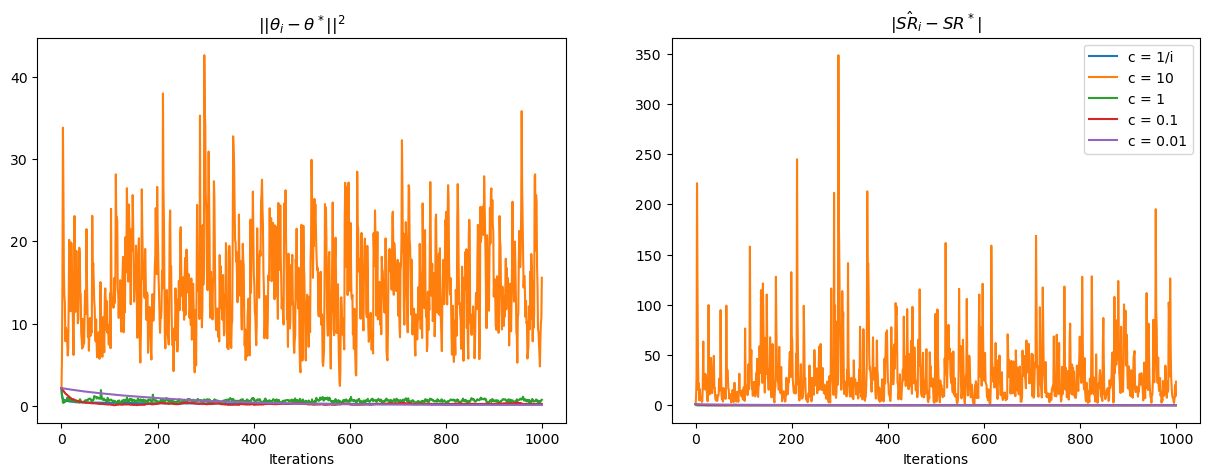

In [6]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

custom_ylim = (0, 2.5)

# Setting the values for all axes.
plt.setp(axs)

labels = ["c = " + str(cc[i]) + "/i"*decay[i] for i in range(len(cc))]

theta_error = []
sr_error = []
for i in range(len(cc)):

    theta_estimates = theta_estimates_exp[i]
    sr_estimates = sr_estimates_exp[i]

    theta_error.append(np.linalg.norm(theta_estimates - true_val, axis=1))
    sr_error.append(np.abs(sr_estimates - sr_val_theta_star))

    axs[0].plot(range(MAX_ITER), theta_error[-1], label = labels[i])
    axs[0].set_title(r"$||\theta_i - \theta^*||^2$")
    axs[0].set_xlabel("Iterations")

    #axs[1].ylim = (0, 0.1)
    axs[1].plot(range(MAX_ITER), sr_error[-1], label = labels[i])
    axs[1].set_title(r"$|\hat{SR}_i - SR^*|$")
    axs[1].set_xlabel("Iterations")

plt.legend()
plt.show()

theta_error = np.array(theta_error)
sr_error = np.array(sr_error)

df_theta = pd.DataFrame(theta_error.T, columns = labels)
df_sr = pd.DataFrame(sr_error.T, columns = labels)

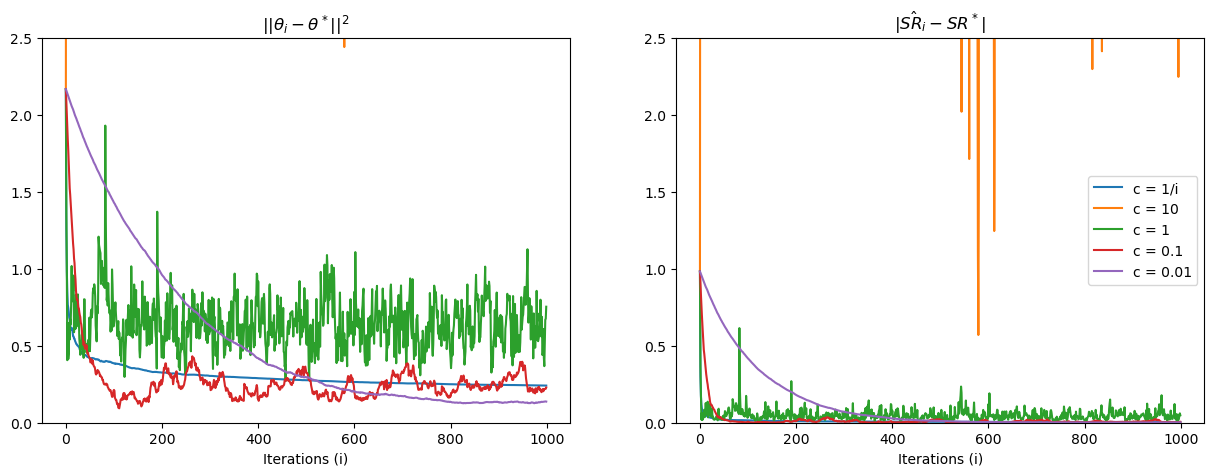

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

custom_ylim = (0, 2.5)

# Setting the values for all axes.
plt.setp(axs, ylim=custom_ylim)

labels = ["c = " + str(cc[i]) + "/i"*decay[i] for i in range(len(cc))]

theta_error = []
sr_error = []

for i in range(len(cc)):
    
    theta_estimates = theta_estimates_exp[i]
    sr_estimates = sr_estimates_exp[i]

    theta_error.append(np.linalg.norm(theta_estimates - true_val, axis=1))
    sr_error.append(np.abs(sr_estimates - sr_val_theta_star))

    axs[0].plot(range(MAX_ITER), theta_error[-1], label = labels[i])
    axs[0].set_title(r"$||\theta_i - \theta^*||^2$")
    axs[0].set_xlabel('Iterations (i)')
    

    axs[1].ylim = (0, 0.1)
    axs[1].plot(range(MAX_ITER), sr_error[-1], label = labels[i])
    axs[1].set_title(r"$|\hat{SR}_i - SR^*|$")
    axs[1].set_xlabel('Iterations (i)')


plt.legend()
plt.show()

In [8]:
theta_error = np.array(theta_error)
sr_error = np.array(sr_error)

df_theta = pd.DataFrame(theta_error.T, columns = labels)
df_sr = pd.DataFrame(sr_error.T, columns = labels)

df_sr.head()

,c = 1/i,c = 10,c = 1,c = 0.1,c = 0.01
0,0.982357,0.982357,0.982357,0.982357,0.982357
1,0.300189,6.786429,0.367350,0.903210,0.973919
2,0.172930,28.350221,0.182984,0.832973,0.967132
3,0.119637,220.957510,0.020343,0.764007,0.958083
4,0.090079,116.954491,0.064617,0.698741,0.948821


In [9]:
# saving all elements as column into a txt file
save = False

if save:
    df_theta.to_csv("theta_error.txt")
    df_sr.to_csv("sr_error.txt")

    np.savetxt("theta_error.txt", theta_error, delimiter=" ")
    np.savetxt("sr_error.txt", sr_error, delimiter=" ")